In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn import decomposition
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV  
import imblearn
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'test.csv', 'train.csv']


In [2]:
!pip install imblearn

     |████████████████████████████████| 167 kB 1.9 MB/s eta 0:00:01


In [4]:
# Read training data
data = pd.read_csv('data/train.csv')
from sklearn.model_selection import train_test_split
train_X = data.drop(["target","id"], axis=1)

# Representation of the target with numerical values 

In [5]:
le = LabelEncoder()
le.fit(data["target"])
train_y = le.transform(data["target"])

# Splitting the data (train.csv)

In [6]:
# split train set into 2 parts with same distribution: 80% train, 20% validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(train_X.values, train_y):
    X_train = train_X.values[train_index]
    X_val = train_X.values[test_index]

    y_train = train_y[train_index]
    y_val = train_y[test_index]

# Preprocessing

## Null values ?

In [7]:
missing_val_count_by_column = (data.isnull().sum())
print(missing_val_count_by_column.sum())

0


In [8]:
data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


## Balance in the class ?

<AxesSubplot:>

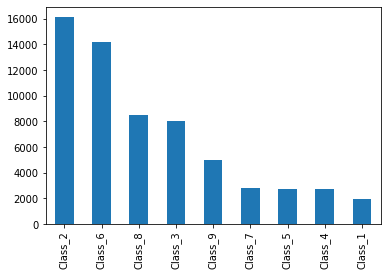

In [34]:
data["target"].value_counts().plot.bar()

In [35]:
data["target"].value_counts()

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64

In [36]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

unique, counts = np.unique(y_ros, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 12898]
 [    1 12898]
 [    2 12898]
 [    3 12898]
 [    4 12898]
 [    5 12898]
 [    6 12898]
 [    7 12898]
 [    8 12898]]


<AxesSubplot:>

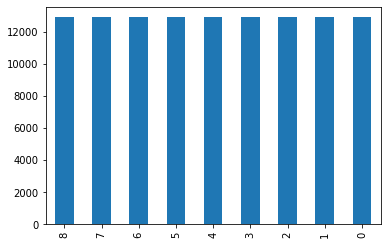

In [12]:
pd.Series(y_ros).value_counts().plot.bar()

## Scaling

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [15]:
test_data = pd.read_csv('data/test.csv')
test_X = test_data.drop(["id"], axis=1)
scaler_all = StandardScaler()
train_X_scaled = scaler_all.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

## PCA ?

In [37]:
pca = decomposition.PCA(n_components=20)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.08591405 0.06558446 0.04157871 0.0317538  0.02837317 0.02615348
 0.02405319 0.02383423 0.02258698 0.02071219 0.01881212 0.01857526
 0.01839444 0.01715568 0.01608632 0.01545303 0.01466367 0.01389867
 0.01354412 0.01274459]
[7.99016843 6.09947757 3.86689781 2.95316277 2.63875777 2.43232317
 2.23699202 2.21662783 2.10063154 1.92627259 1.74956221 1.72753394
 1.71071721 1.59551093 1.49605767 1.43716085 1.36374892 1.29260262
 1.2596284  1.18527111]


## Determine number of components

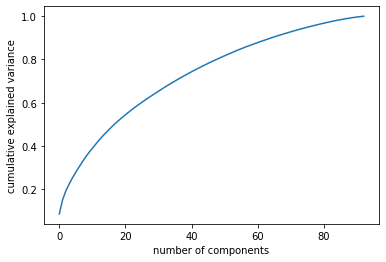

In [38]:
pca = decomposition.PCA()
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
#print(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

At least 95% of the variance in the data can be explained by 77 components.

# XGBOOST

In [39]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)
preds = xgb.predict_proba(X_val_scaled)
score = log_loss(y_val, preds)
print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.47193172798915767


In [19]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

# Fitting and Tuning an Algorithm

In [20]:
from sklearn.model_selection import GridSearchCV

"""
param_test = {
    'n_estimators': [300],
    'n_jobs': [4], #Number of jobs to run in parallel. -1 means using all processors
}
gsearch = GridSearchCV(estimator = XGBClassifier(), param_grid = param_test, scoring='neg_log_loss', n_jobs=-1,iid=False, cv=3,verbose=1, return_train_score=True)
gsearch.fit(X_train_scaled,y_train)
pd.DataFrame(gsearch.cv_results_)
"""

"\nparam_test = {\n    'n_estimators': [300],\n    'n_jobs': [4], #Number of jobs to run in parallel. -1 means using all processors\n}\ngsearch = GridSearchCV(estimator = XGBClassifier(), param_grid = param_test, scoring='neg_log_loss', n_jobs=-1,iid=False, cv=3,verbose=1, return_train_score=True)\ngsearch.fit(X_train_scaled,y_train)\npd.DataFrame(gsearch.cv_results_)\n"

In [21]:
scores = []
n_estimators = [100,200,400,450,500,525,550,600,700]

for nes in n_estimators:
    xgb = XGBClassifier(learning_rate =0.1, n_estimators=nes, max_depth=7, min_child_weight=3, subsample=0.8, 
                             colsample_bytree=0.8, nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.5066036970722967
test data log loss eval : 0.46427228076588345
test data log loss eval : 0.4412865194063501
test data log loss eval : 0.43994034621197414
test data log loss eval : 0.4386005813433039
test data log loss eval : 0.4388638149269486
test data log loss eval : 0.438999378626812
test data log loss eval : 0.43942610973273394
test data log loss eval : 0.4427843429479773


best n_estimator 500


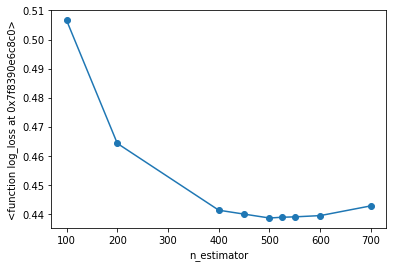

In [22]:
plt.plot(n_estimators,scores,'o-')
plt.ylabel(log_loss)
plt.xlabel("n_estimator")
print("best n_estimator {}".format(n_estimators[np.argmin(scores)]))

In [23]:
scores_md = []
max_depths = [1,3,5,6,7,8,10]

for md in max_depths:
    xgb = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators[np.argmin(scores)], 
                        max_depth=md, min_child_weight=3, subsample=0.8, 
                        colsample_bytree=0.8, nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores_md.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.657507658704857
test data log loss eval : 0.5073943273790009
test data log loss eval : 0.4542139749613389
test data log loss eval : 0.44320314823798124
test data log loss eval : 0.4386005813433039
test data log loss eval : 0.43795689470287763
test data log loss eval : 0.4484188321891942


best max_depth 8


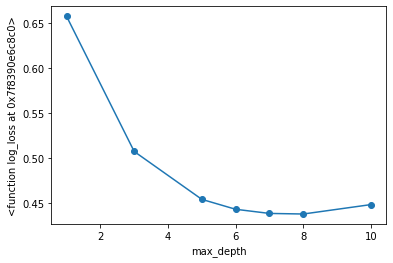

In [24]:
plt.plot(max_depths,scores_md,'o-')
plt.ylabel(log_loss)
plt.xlabel("max_depth")
print("best max_depth {}".format(max_depths[np.argmin(scores_md)]))

In [25]:
scores_mcw = []
min_child_weights = [1,2,3,4,5]

for mcw in min_child_weights:
    xgb = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators[np.argmin(scores)],
                        max_depth=max_depths[np.argmin(scores_md)], 
                        min_child_weight=mcw, subsample=0.8, 
                        colsample_bytree=0.8, nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores_mcw.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.44505578701691806
test data log loss eval : 0.44104598127046196
test data log loss eval : 0.43795689470287763
test data log loss eval : 0.43801885839586846
test data log loss eval : 0.4377712916245383


best min_child_weight 5


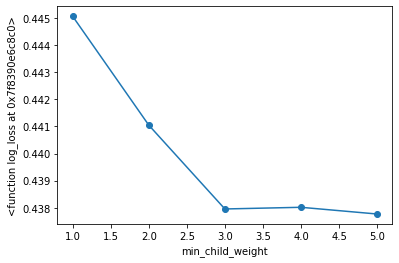

In [26]:
plt.plot(min_child_weights,scores_mcw,"o-")
plt.ylabel(log_loss)
plt.xlabel("min_child_weight")
print("best min_child_weight {}".format(min_child_weights[np.argmin(scores_mcw)]))

In [27]:
scores_ss = []
subsamples = [0.5,0.6,0.7,0.8,0.9,1]

for ss in subsamples:
    xgb = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators[np.argmin(scores)], 
                        max_depth=max_depths[np.argmin(scores_md)],
                        min_child_weight=min_child_weights[np.argmin(scores_mcw)], subsample=ss, 
                        colsample_bytree=0.8, nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores_ss.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.44267612354773755
test data log loss eval : 0.4379678754829687
test data log loss eval : 0.43999917115832615
test data log loss eval : 0.4377712916245383
test data log loss eval : 0.43888828374738215
test data log loss eval : 0.4456789445062111


best subsample 0.8


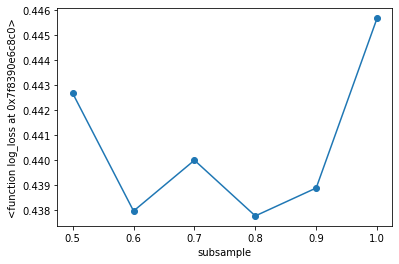

In [28]:
plt.plot(subsamples,scores_ss,"o-")
plt.ylabel(log_loss)
plt.xlabel("subsample")
print("best subsample {}".format(subsamples[np.argmin(scores_ss)]))

In [29]:
scores_cb = []
colsample_bytrees = [0.5,0.6,0.7,0.8,0.9,1]

for cb in colsample_bytrees:
    xgb = XGBClassifier(learning_rate =0.1, n_estimators=n_estimators[np.argmin(scores)], 
                        max_depth=max_depths[np.argmin(scores_md)], 
                        min_child_weight=min_child_weights[np.argmin(scores_mcw)], 
                        subsample=subsamples[np.argmin(scores_ss)], 
                        colsample_bytree=cb, nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores_cb.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.4361463702609223
test data log loss eval : 0.4352840024250346
test data log loss eval : 0.43820476578403633
test data log loss eval : 0.4377712916245383
test data log loss eval : 0.43835266226956926
test data log loss eval : 0.43902211436963123


best colsample_bytree 0.6


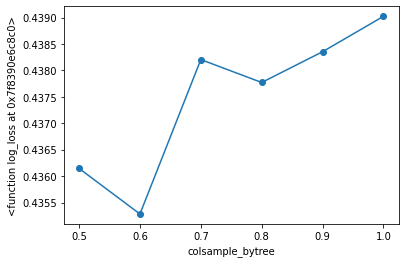

In [30]:
plt.plot(colsample_bytrees,scores_cb,"o-")
plt.ylabel(log_loss)
plt.xlabel("colsample_bytree")
print("best colsample_bytree {}".format(colsample_bytrees[np.argmin(scores_cb)]))

In [31]:
scores_eta = []
etas = [0.001,0.01,0.1,0.2,0.3,0.5,1]

for eta in etas:
    xgb = XGBClassifier(learning_rate =eta, n_estimators=n_estimators[np.argmin(scores)], 
                        max_depth=max_depths[np.argmin(scores_md)], 
                        min_child_weight=min_child_weights[np.argmin(scores_mcw)], 
                        subsample=subsamples[np.argmin(scores_ss)], 
                        colsample_bytree=colsample_bytrees[np.argmin(scores_cb)], 
                        nthread=4, seed=42, objective='multi:softprob')
    xgb.fit(X_train_scaled, y_train)
    preds = xgb.predict_proba(X_val_scaled)
    score = log_loss(y_val, preds)
    scores_eta.append(score)
    print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 1.5198495797981504
test data log loss eval : 0.5813344305370042
test data log loss eval : 0.4352840024250346
test data log loss eval : 0.46248974167425877
test data log loss eval : 0.5001584509259224
test data log loss eval : 0.5770722626769836
test data log loss eval : 0.7614980595327123


best eta 0.1


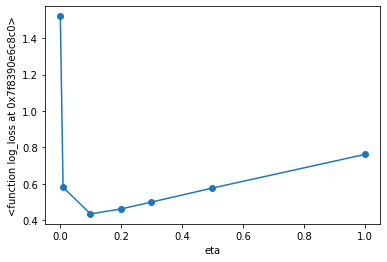

In [32]:
plt.plot(etas,scores_eta,"o-")
plt.ylabel(log_loss)
plt.xlabel("eta")
print("best eta {}".format(etas[np.argmin(scores_eta)]))

In [41]:
xgb = XGBClassifier(learning_rate =eta, n_estimators=n_estimators[np.argmin(scores)], 
                        max_depth=max_depths[np.argmin(scores_md)], 
                        min_child_weight=min_child_weights[np.argmin(scores_mcw)], 
                        subsample=subsamples[np.argmin(scores_ss)], 
                        colsample_bytree=colsample_bytrees[np.argmin(scores_cb)], 
                        nthread=4, seed=42, objective='multi:softprob')
calibrated_xgb = CalibratedClassifierCV(xgb, cv=5, method='isotonic')
calibrated_xgb.fit(X_train_scaled, y_train)
preds = calibrated_xgb.predict_proba(X_val_scaled)
score = log_loss(y_val, preds)
scores_eta.append(score)
print("test data log loss eval : {}".format(log_loss(y_val,preds)))

test data log loss eval : 0.4712586850861301


# submission